<h1>Prediction of weather</h1>

From the aqueduct of Segovia to the Pont de Gard in France, mankind has always been battling nature and finding ways to survive in one way or another. In recent years, climate change is increasingly affecting the lives of everyone in the world. Extreme weather has also been more frequent. Weather situations such as heavy rainfall could happen quickly with little warning. In February and March this year, heavy rain hit southern Malaysia and Singapore, resulting in flash floods and even landslides in some cases. Thus, this report will try to reduce the severity of the impact on the people by attempting to predict rainfall based on a range of features. This report has made extensive reference to the book Deep Learning with Python by Francois Chollet. It is developed based on "the universal workflow of machine learning" described in chapter 4.5 of the book.

The cell below enables MathJax on the jupyter notebook. This is used to render the LaTeX code correctly in the submitted html version of the report.

In [1]:
%%javascript
MathJax.Hub.Config({
  TeX: { 
    extensions: ["color.js"],
    equationNumbers: { autoNumber: "AMS" },
    Macros: { bm: "\\boldsymbol" }
  },
  displayAlign: "center",
  "HTML-CSS": { linebreaks: { automatic: true } },
  SVG: { linebreaks: { automatic: true } }
});


<IPython.core.display.Javascript object>

<h2>Table of content</h2>

[1. Defining the problem and assembling the dataset](#chpt1)

[2. Choosing a measure of success](#chpt2)

[3. Deciding on an evaluation protocol](#chpt3)

[4. Prepare the data](#chpt4)

[5. Developing a model that does better than a baseline](#chpt5)

[6. Scaling up: developing a model that overfits](#chpt6)

[7. Regularizing the model and tuning hyperparameters](#chpt7)

<p style="page-break-after:always;"></p>

<h2 id='chpt1'>1. Defining the problem and assembling the dataset</h2>

<h3>1.1 Choice of input</h3>

As chollet mentioned in Chapter 4.5.1, data availability is one of the limiting factor for a machine learning project. As this report targets to protect people from extreme weather situations, especially heavy rainfall, I have chosen a dataset from the [Australia Weather Data](https://www.kaggle.com/datasets/arunavakrchakraborty/australia-weather-data) avaliable on Kaggle. 

Based on the information avaliable on the website, this dataset covers a range of key weather conditions, such as rainfall, wind speed, humidity, and atmospheric pressure. Some of the data are also available at different times of the day. Moreover, the dataset has a large sample size as it contains weather observation daily for about <b>10 years</b>. Another feature that set this dataset apart from others is that this was <b>updated 6 months ago</b>. This is very important as it is very up-to-date.

On the other hand, the data source has been quoted in the description of the dataset. It is obtained from the [Bureau of Meteorology of Australia](http://www.bom.gov.au/climate/data/). It is an opensource data from a <b>credible government agency</b>.

<h3 id="chpt1.2">1.2 Import the data and preliminary analysis</h3>

The data is avalaible for download from the above mentioned link. As describe on the webpage, it was apparent that the data has already been seperated into a test and training data in their original csv file. Both file are avaliable for download as 'Weather Test Data.csv' and 'Weather Training Data.csv'. However, the 'Weather Test Data.csv' is missing one column (RainTomorrow). This column is essential to the research. Thus, this paper will soly based on the 'Weather Training Data.csv'. It is still a sufficiently big dataset with <b>99516 unique values</b>. Although the data has already been explored and used for prediction, the exploration did not focus on the deep learning using neural network. This makes this report still <b>novel</b> to the topic.

In [2]:
# import modules for data processing
import pandas as pd
import numpy as np

In [3]:
org_data = pd.read_csv('data/Weather Training Data.csv')
org_data.head()

,row ID,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Row0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0
1,Row1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0
2,Row2,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0
3,Row3,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,0
4,Row4,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,0


In [4]:
org_data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
count,99073.000000,99286.000000,98537.000000,56985.00000,52199.000000,93036.000000,98581.000000,97681.000000,98283.000000,97010.000000,89768.000000,89780.000000,61944.000000,59514.000000,98902.000000,97612.000000,99516.000000
mean,12.176266,23.218513,2.353024,5.46132,7.615090,39.976966,14.004849,18.650464,68.866376,51.433296,1017.684638,1015.286204,4.447985,4.519122,16.970041,21.681340,0.224677
std,6.390882,7.115072,8.487866,4.16249,3.783008,13.581524,8.902323,8.801827,19.074951,20.777616,7.110166,7.045189,2.886580,2.716618,6.488961,6.931681,0.417372
min,-8.500000,-4.100000,0.000000,0.00000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,978.200000,0.000000,0.000000,-7.000000,-5.100000,0.000000
25%,7.600000,17.900000,0.000000,2.60000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.000000,1010.500000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.80000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.700000,1015.300000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.800000,7.40000,10.600000,48.000000,19.000000,24.000000,83.000000,65.000000,1022.400000,1020.000000,7.000000,7.000000,21.500000,26.400000,0.000000
max,33.900000,48.100000,371.000000,86.20000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,1.000000


In [5]:
#check if the classification is unbalanced
num_norain=(org_data['RainTomorrow']==0).sum()
num_rain=(org_data['RainTomorrow']==1).sum()

print('Number of no raining days:'+str(num_norain))
print('Number of raining days:'+str(num_rain))

Number of no raining days:77157
Number of raining days:22359


Based on the above analysis, there are some <b>missing values</b> that need to be cleaned before carrying out the machine learning process. Some of the values only have slightly more than 50000 inputs. The <b>target feature</b> to be predicted is located in the last column 'RainTomorrow', which contains a boolean value of 0 or 1. This column has <b>99516 data entries</b>. Missing values for all columns, except for the target feature could be imputed using <b>K Nearest Neightbour</b>. As the number of days that are raining is about 3 times smaller than that of the days that are not raining. As the difference between the two classes is significant, the dataset is <b>imbalanced</b>.

<h3>1.3 Result to be predicted</h3>

The result of this machine learning algorithm should be able to predict whether it will be raining tomorrow. It will be categorised into exclusively two different categories, raining or not raining. In machine learning terms, as described in chapter 3.4 of Deep Learning with Python by Chollet, this will be a two-class classification or *binary classification*. There will be two output classes ending with a 'Dense' layer with a 'sigmoid' activation. Stacking the 'Dense' layer with 'relu' activation is recommended by the book to solve a larger scale of problems. For the optimizer, "rmspop" is recommended as a suitable choice. The result should be a probability between 0 and 1. 

<h3>1.4 Assumptions</h3>

Although whether or not it will be raining tomorrow is a nonstationary problem as the weather condition such as evaporation, sunshine, and wind direction varies are affected significantly by the season as well. However, the dataset obtained is large enough to contain all the season's variation and potential abnormalities as it is collected for "about 10 years". Thus, it is fair to say that the dataset collected can fulfill the purpose of this research.

As the weather is governed by the same set of physics and thermal dynamic rules, it could be suitable to apply a machine learning(ML) algorithm to it as ML assumes that the future behaves in a similar manner as in the past.

<h2 id='chpt2'>2. Choosing a measure of success</h2>

A measure of success is of paramount importance for the optimization of the project. For this particular model, if the result identified is a false negative, the people could go to an area prone to flood and landslides without knowing the incoming danger. However, if the result is identified as a false positive, it is less of a concern as the lives are not in immediate danger. With reference to the equation of recall below, focuses on finding the percentage of True Positive correctly identified. 

In this case, identifying all potential rainfall is more important, and this model will focus on improving the <b>recall</b>. However, <b>precision</b> will also be calculated as part of the evaluation.

$$
recall = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}
$$

Moreover, accuracy is also a good measure of success. However, the preliminary data analysis in [section 1.2](#chpt1.2) showed that the size of the class of the none raining days is significantly larger than that of rainy days. The dataset is thus imbalanced. An imbalanced data could cause the accuracy result to be misleading as it tends towards the class with larger data size (none rainy days). Thus, a [<b>Balanced Accuracy Score</b>](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) is used to replace the accuracy as it takes into account the sample size in each class. 

$$
Balanced\ Accuracy\ Score = \frac{1}{2}\left(\frac{True Positive}{True Positive + False Negative}+\frac{True Negative}{True Negative + False Positive}\right)
$$

Lastly, although this problem has been identified as class-imbalanced, the <b>area under the receiver operating characteristic curve(ROC AUC)</b> will still be calculated as a supplementary to the above-mentioned measures.

<h2 id='chpt3'>3. Deciding on an evaluation protocol</h2>

With reference to chapter 4.2.1 of Deep Learning with Python by Chollet, there are three main methods for evaluation. These include simple hold-out validation, k-fold validation, and iterated k-fold validation with shuffling. 

For this project, the <b>hold-out validation </b> and <b>k-fold validation</b> will be used. 

For the <b>hold-out validation</b>, a proportion of the data available is reserved as validating data ('held-out validation set'). The model is trained with the rest of the data and then test on the reserved set of data to evaluate the performance. This is one of the easiest methods for evaluation, with the only disadvantage as it needs more data to b set aside. This project has a <b>large dataset</b> of more than 90000 data entries, making the hold-out validation a good choice of evaluation.

While the <b>k-fold validation</b> splits the data into partitions of the same size and iteratively trains/tests on different sets of partitions. This could help if the model showed large variations based on the train test split. As this situation is <b>potentially possible</b>, the model will use the k-fold validation as another evaluation protocol

The last method with shuffling iterated k-fold validation, as the name suggests, applies the k-fold validation multiple times with different shuffling of data. This method is very helpful <b>if the data size is small</b>. However, as the dataset obtained has more than 90000 data entries, the model developed does not really need such practice.

<h2 id='chpt4'>4. Prepare the data</h2>

The data obtained on [section 1.2](#chpt1.2) needs to be reformat into tensors so that it can be feed into a deep learning neural network. Firstly, the data is cleaned on the column followed by the rows. This includes removing unused columns and using k nearest neighbour to impute the missing values in the row.

<h3 id="chpt4.1">4.1 Data Cleaning for column</h3>

The dataframe will first be saperated into weather_data which contains the <b>categorical weather information</b> and <b>numerical weather information</b>. This is done such that the KNN imputer can work based on numerical and categorical data separately. As the column rain tomorrow is not about the current weather, it will be in a different dataframe.

In [6]:
#show the orginal data imported
org_data.head()

,row ID,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Row0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0
1,Row1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0
2,Row2,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0
3,Row3,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,0
4,Row4,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,0


In [7]:
# creating the dataframe for numerical data
num_weather = org_data[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 
                       'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
                       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
                       'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']]
num_weather.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,13.4,22.9,0.6,NaN,NaN,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8
1,7.4,25.1,0.0,NaN,NaN,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3
2,17.5,32.3,1.0,NaN,NaN,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7
3,14.6,29.7,0.2,NaN,NaN,56.0,19.0,24.0,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9
4,7.7,26.7,0.0,NaN,NaN,35.0,6.0,17.0,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5


In [8]:
#creating the dataframe for categorical data
cat_weather = org_data.copy()
cat_weather=cat_weather.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 
                       'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
                       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
                       'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm','RainTomorrow','row ID'], axis=1)
cat_weather.head()

,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday
0,Albury,W,W,WNW,No
1,Albury,WNW,NNW,WSW,No
2,Albury,W,ENE,NW,No
3,Albury,WNW,W,W,No
4,Albury,W,SSE,W,No


In [9]:
#creating dataframe for the target(rain tomorrow)
target = org_data[['RainTomorrow']]
target.head()

,RainTomorrow
0,0
1,0
2,0
3,0
4,0


As only the column is cleaned, the number of rows in the orginal dataframe and the different dataframe should be the same. The cell below varifies that the rows are not affected by the above cleaning process

In [10]:
# compare the number of rows in original dataframe and the feature dataframe
if target.shape[0] == org_data.shape[0]==cat_weather.shape[0]==num_weather.shape[0]:
    print("row unaffected")
else:
    print('error')

row unaffected


In [11]:
#obtain the column names to prepare for knn
num_data = list(num_weather.columns)
cat_data = list(cat_weather.columns)

<h3>4.2 Data Cleaning for row</h3>

KNN imputer is used to impute the missing values

In [12]:
#import the modules needed for imputing
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

In [13]:
#define the test size and random seed
size = 0.10
seed = 66

In [14]:
#obtain all features
features = org_data[num_data + cat_data]

The train_test_split from scikit-learn is used to split the features and target into training and testing sets for machine learning. The test_size is set as 10 such that 10% of the data is used for testing and 90% of the data is used for training. As the data input is imbalanced, stratify parameter is used such that both rainy and non-rainy days will have same propotion in training and testing sets. Shuffle is set as true so that the data is randomly arranged before splitting them into test and training set. The randomn state is set as seed (66) so that the result is repeatable.

In [15]:
#the features is then split into the training and testing data sets
(X_feature_train, X_feature_test, y_feature_train, y_feature_test) = train_test_split(features, target, 
                                                          test_size=size, stratify=target,
                                                          shuffle=True, random_state=seed)

<b>Finding X train and test</b>

In [16]:
#import for one hot endcoding and standardscalar
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

KNNImputer is used to impute the missing values. In this case, the n_neighbor will be set as 5 such that 5 nearest neighbour is used to impute the value by fitting the training set's numeric data. Then a transform method is used on both training and testing data to transform their missing values to imputed values caculated by the imputer

In [17]:
# impute missing values in the numerical features
knn_imp = KNNImputer(n_neighbors=5).fit(X_feature_train[num_data])
num_feature_train = knn_imp.transform(X_feature_train[num_data])
num_feature_test = knn_imp.transform(X_feature_test[num_data])

The categorical data are checked for missing values. Then new dataframe for training and testing set for categorical data is formed and filled missing value with numpy na.

In [18]:
X_feature_test[cat_data].isnull().sum()

Location         0
WindGustDir    694
WindDir9am     713
WindDir3pm     284
RainToday       86
dtype: int64

In [19]:
X_feature_train[cat_data].isnull().sum()

Location          0
WindGustDir    5827
WindDir9am     6293
WindDir3pm     2364
RainToday       893
dtype: int64

In [20]:
cat_feature_train = X_feature_train[cat_data].fillna('a')
cat_feature_test = X_feature_test[cat_data].fillna('a')

Then the categorical data and numerical data is combine forming a new dataframe with imputed numercial value filled

In [21]:
#combine the imputed numerical features and categorical features for training set
num_feature_train = pd.DataFrame(num_feature_train, columns=num_data).reset_index(drop=True)
cat_feature_train = cat_feature_train.reset_index(drop=True)

Xcombine_train = pd.concat([num_feature_train, cat_feature_train], axis=1)
Xcombine_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday
0,9.6,13.8,0.8,0.8,1.20,35.0,9.0,20.0,67.0,60.0,...,1032.2,8.0,8.0,12.0,12.9,Portland,W,WSW,W,No
1,9.4,25.5,0.0,4.8,11.54,44.0,6.0,15.0,68.0,35.0,...,1014.9,1.6,3.2,14.4,23.3,Tuggeranong,W,WNW,N,No
2,14.7,21.3,0.2,9.0,3.20,35.0,7.0,11.0,69.0,86.0,...,1013.2,7.0,8.0,17.9,16.9,Watsonia,W,SW,SW,No
3,7.9,26.2,0.0,8.0,11.20,30.0,19.0,6.0,61.0,25.0,...,1010.4,3.0,7.0,17.0,25.4,WaggaWagga,ENE,ENE,W,No
4,15.5,24.9,0.0,8.0,11.66,39.0,7.0,20.0,56.0,52.0,...,1018.9,1.0,1.0,21.0,24.1,Sydney,NE,W,NE,No


In [22]:
#combine the imputed numerical features and categorical features for testing set
num_feature_test = pd.DataFrame(num_feature_test, columns=num_data).reset_index(drop=True)
cat_feature_test = cat_feature_test.reset_index(drop=True)

Xcombine_test = pd.concat([num_feature_test, cat_feature_test], axis=1)
Xcombine_test.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday
0,7.7,22.5,0.0,5.20,9.10,100.0,57.0,76.0,53.0,34.0,...,1010.50,3.0,6.0,13.0,19.8,Melbourne,N,N,N,No
1,9.1,15.5,0.0,1.20,3.60,31.0,19.0,17.0,78.0,80.0,...,1025.80,8.0,8.0,14.5,14.4,Portland,ESE,ESE,SE,No
2,6.2,15.7,0.2,0.80,3.40,52.0,9.0,22.0,86.0,73.0,...,1004.50,8.0,6.0,11.1,15.3,Nuriootpa,WNW,N,NW,No
3,12.3,19.0,3.4,1.80,3.90,70.0,24.0,41.0,70.0,55.0,...,994.20,7.0,7.0,14.4,18.4,Melbourne,N,N,N,Yes
4,0.2,11.0,0.0,2.88,7.48,50.0,22.0,11.0,95.0,90.0,...,1014.18,6.2,6.4,5.0,7.7,MountGinini,WSW,SW,WSW,No


The categorical data is encoded using <b>one-hot encoding</b> which turns the value into vetors 0 and 1. This would be useful later for the Dense layer of the nerual networks which handles floating point vector data. It only takes in the predefined list of data in cat_data and ignores all the unknowns.

With reference to [section 1.2](#chpt1.2), the magitude of the data varies from in 10<sup>3</sup> and 10<sup>1</sup>, there is a significant difference in magitude. Thus the numerical data is standardized using <b>standard scaler</b> method as shown [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

Instead of the method as demonstrated in chapter 3.4.2 of the Deep Learning with Python, code below took reference from a post with similar problem in [stackoverflow](https://stackoverflow.com/questions/54160370/how-to-use-sklearn-column-transformer). Which utilises a preprocessor.

In [23]:
# defining the preprocessor
preprocessor = ColumnTransformer([
    ('one-hot-encoder', OneHotEncoder(handle_unknown="ignore"), cat_data),
    ('standard_scaler', StandardScaler(), num_data)])

In [24]:
#fit the data into the preprocessor
preprocessor.fit(Xcombine_train)

ColumnTransformer(transformers=[('one-hot-encoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Location', 'WindGustDir', 'WindDir9am',
                                  'WindDir3pm', 'RainToday']),
                                ('standard_scaler', StandardScaler(),
                                 ['MinTemp', 'MaxTemp', 'Rainfall',
                                  'Evaporation', 'Sunshine', 'WindGustSpeed',
                                  'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                                  'Humidity3pm', 'Pressure9am', 'Pressure3pm',
                                  'Cloud9am', 'Cloud3pm', 'Temp9am',
                                  'Temp3pm'])])

Next the data is transformed using the preprocessor. The transform method calls the one-hot-encoder (categorical data) and standard scaler (numerical data) as identified in the column transformer. The result is saved as X_train and X_test for future machine learning.

In [25]:
#transform the data using preprocessor
X_train, X_test = preprocessor.transform(Xcombine_train), preprocessor.transform(Xcombine_test)

In [26]:
X_train, X_test

(<89564x119 sparse matrix of type '<class 'numpy.float64'>'
 	with 1880844 stored elements in Compressed Sparse Row format>,
 <9952x119 sparse matrix of type '<class 'numpy.float64'>'
 	with 208992 stored elements in Compressed Sparse Row format>)

<b>Finding y train and test</b>

For the y_feature train and test, as there is only two binary category (rain or not rain), a <b>labeled encoding</b> is recommened. It assigns 0 to one data and 1 to the other. However, with reference to the table for RainTomorrow section [4.1](#chpt4.1) as well as below, the value in RainTomorrow column is already in 0 and 1. Thus there is no need to apply the label encoding and the column is ready to be used.

In [27]:
target.RainTomorrow.unique()

array([0, 1], dtype=int64)

In [28]:
y_train = y_feature_train
y_test = y_feature_test

<b>Split for Validation</b>

As mentioned in [section 3](#chpt3), both hold-out validation and k-fold validation will be used. Thus there is a need to reserve a propotion of data for validation in the training set. This is split using the similar way as the train test split. The only difference is that instead of splitting for test set, the code below splits for the validation set. The size of validation set is set as vali (12.5% of training data). The result is saved as using_X_train and using_y_train to differentiate from the one without validation

In [29]:
vali=0.125
using_X_train, X_vali, using_y_train, y_vali = train_test_split(X_train, y_train, 
                                                  test_size=vali, stratify=y_train,
                                                  shuffle=True, random_state=seed)

In [30]:
using_X_train

<78368x119 sparse matrix of type '<class 'numpy.float64'>'
	with 1645728 stored elements in Compressed Sparse Row format>

<h2 id='chpt5'>5. Developing a model that does better than a baseline</h2>

A baseline is essential for the success of the model as it is used as a bench mark to evaluate how good or bad the particular model perform. Evatually, the aim of the nerual network is to develop a model such that it has better performance as compared to the baseline. The model is evaluated based on the pre-determined set of measures of success. The recall, precision, Balanced Accuracy Score and AUG where indentified as the measure of success in [section 2](#chpt2).

There are a few ways to indentify a baseline, one way is to use a random baseline as recomended in chapter 3.5.4 of the Deep learning with Python by Chollet. It is a simple algorithm as it makes a random prediction.

<h3>5.1 Building Model</h3>

In [59]:
# import the required modeuls for deep learning model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

# import models for testing, validation and baseline
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

With reference to chapter 3.4.3 of the Deep Learning With Python by Chollet, as this problem is also a binary classification, the model will be built using <b>Dense</b> layer with <b>relu</b> activation. As this is the first model, an arbitory set of hyperparameters will be manually defined. As recomended in [Video 10.509](https://www.coursera.org/learn/uol-cm3015-machine-learning-and-neural-networks/lecture/lkS9A/10-509-developing-a-model-that-does-better-than-the-baseline) of this course, it is optimal for binary classification problems to have sigmoid activation for the last layer and binary_crossentropy as the loss function. Thus, the model will end with an output layer with <b>sigmoid activation</b> and loss function of <b>binary_crossentropy</b>. The rmsprop optimizer is used as guided in chapter 3.6.3 of the Deep Learning With Python by Chollet.

For deep learning, there must be at least 3 layers. Thus 2 hidden layers and 1 output layer will be used in a sequential manner.

In [32]:
# set hyperparameters for hidden layers
hidden_layers = 0
unit = 16
activation = 'relu'
input_shape = X_train.shape[1]
dropout = 0.2

# set hyperparameters for hidden layers
output_unit = 1
optimizer = 'rmsprop'

# set the compling parameters
loss_function = 'binary_crossentropy'
metrics = ['accuracy',tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

In [33]:
#create the model
fst_model = Sequential()

#add hidden layers
for layer in range(hidden_layers):
    fst_model.add(Dense(unit, activation=activation, input_shape=(input_shape,)))
    if dropout > 0.0:
        fst_model.add(Dropout(dropout))

#add output layer
fst_model.add(Dense(output_unit, activation='sigmoid'))

#build the model
fst_model.build((None,input_shape))

#compile the model
fst_model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

In [34]:
fst_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 120       
                                                                 
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


<h3>5.2 Training the model</h3>

To train the model, the parameter of the model need first to be defined. The input data, namly using_X_train, X_vali, using_y_train, y_vali were already defined in section 4 of this report. The other varibles that needs to be defined includes batch size, epochs, and verbose.

Batch size refers to the number of training samples used in each iteration (gradient descent, for example), then the epochs defines the number of training passes. For instance, my code below passes <b>256 sample</b> in each iteration, the entire date is passes through the learning algorithm <b>100 times</b>.

Verbose is used to display the training information. History1 is used for the model history.

In [35]:
#varibales
batch_size = 256
epochs = 100

As the data is unbalanced, the weight of the class need tp be specified

In [36]:
unique_classes = np.unique(using_y_train)
class_counts = np.bincount(using_y_train.to_numpy().ravel())
class_weights = {cls: len(using_y_train) / (len(unique_classes) * class_counts[i]) for i, cls in enumerate(unique_classes)}
class_weights

{0: 0.6448979591836734, 1: 2.2253521126760565}

In [37]:
#train the model on the training data
history1 = fst_model.fit(using_X_train.toarray(), using_y_train.to_numpy(), class_weight=class_weights,
                    batch_size=batch_size, epochs=epochs, 
                    validation_data=(X_vali.toarray(), y_vali.to_numpy()),
                    verbose=0)

# Evaluate the model on the validation data and return the results
vali_score = fst_model.evaluate(X_vali.toarray(), y_vali.to_numpy(), verbose=0)[1:]

In [38]:
output = {'model': fst_model, 'vali_score': vali_score, 'history': history1}

output of the neural network is as follow:

In [39]:
print({'model': fst_model, 'vali_score': vali_score, 'history': history1})

{'model': <keras.engine.sequential.Sequential object at 0x000001CF864C0590>, 'vali_score': [0.799035370349884, 0.5366325974464417, 0.7717694044113159, 0.8754693865776062], 'history': <keras.callbacks.History object at 0x000001CF878A89D0>}


<h3>5.3 Setting baseline</h3>

The start of [this section](#chpt5) mentioned  using the random baseline. However, upon some research, there are also [other forms](https://datascience.stackexchange.com/questions/30912/what-does-baseline-mean-in-the-context-of-machine-learning) of baseline available such as prediction based on works done by others and predicting the most common case. As this task handles an unbalanced binary classification with unbalanced data, it makes sense logically to predict the most common case.

In [40]:
count_unique_entries = target["RainTomorrow"].value_counts()
count_unique_entries

0    77157
1    22359
Name: RainTomorrow, dtype: int64

As the data shows predominently 0(no rain), the most frequent cases is 0 and the baseline will be always predicts that there will be no rain tomorrow.

In [41]:
num_zeros = count_unique_entries[0]
total_count = count_unique_entries.sum()
baseline_ac = (num_zeros +0) / (total_count +0+0)
print("baseline accuracy of always predicting 0 in RainTomorrow column: {:.5f}".format(baseline_ac))

baseline accuracy of always predicting 0 in RainTomorrow column: 0.77532


In [42]:
baseline_bac=balanced_accuracy_score(y_train, np.zeros(len(y_train)))
print("baseline balanced accuracy score of always predicting 0 in RainTomorrow column: {:.5f}".format(baseline_bac))

baseline balanced accuracy score of always predicting 0 in RainTomorrow column: 0.50000


In [43]:
baseline_rc = recall_score(y_train, np.zeros(len(y_train)), pos_label=0)
print("baseline recall of always predicting 0 in RainTomorrow column: {:.5f}".format(baseline_rc))

baseline recall of always predicting 0 in RainTomorrow column: 1.00000


In [44]:
num_zeros = count_unique_entries[0]
total_count = count_unique_entries.sum()
baseline_pr = num_zeros / total_count
print("baseline precision of always predicting 0 in RainTomorrow column: {:.5f}".format(baseline_pr))

baseline precision of always predicting 0 in RainTomorrow column: 0.77532


It is worth noting that due to the nature of the baseline (everything predicts 0) there will not be any false negative value in the baseline situation. This results in the baseline score for recall being redundant as it cannot give any useful information to the model. Moreover, the numerical value of accuracy and precsion will be the same as there is no negative value predicted. Thus, accuracy will be used instead.

<h3>5.4 Comparison between the learning and baseline</h3>

As the balanced accuray score has not being calculated, the code below generates the balanced accuracy score for the model.

In [84]:
def model_validation(model,y_val,baseline_balance_accuracy,baseline_accuracy,baseline_precision,baseline_recall,validity_score):
    '''
    evaluate the model's validity
    Arg:
    model: machine learning model
    y_val:validity set in the testing data
    validity_score: machine learning model evaluation
    baseline_balance_accuracy,baseline_accuracy,baseline_precision,baseline_recall:
    the respective measure on baseline case
    
    outputs:
    none
    '''
    prediction = (fst_model.predict(X_vali, verbose=0) > 0.5).astype('int32')
    vali_bas = balanced_accuracy_score(y_val, prediction)
    print('Validation accracy balanced accuracy score: {:.2f}'.format(vali_bas))
    print("baseline balanced accuracy score: {:.2f}".format(baseline_balance_accuracy))
    if vali_bas > baseline_bac:
        print('a better model is developed')
    else:
        print('model is not good')
    
    print("-" * 50)

    print('Validation accracy: {:.2f}'.format(validity_score[0]))
    print("baseline accuracy: {:.2f}".format(baseline_accuracy))
    if vali_score[0] > baseline_ac:
        print('a better model is developed')
    else:
        print('model is not good')
        
    print("-" * 50)
    
    print('Validation precision: {:.2f}'.format(validity_score[1]))
    print("baseline precision: {:.2f}".format(baseline_precision))
    print("-" * 50)
    
    print('Validation recall: {:.2f}'.format(validity_score[2]))
    print("baseline recall: {:.2f}".format(baseline_recall))
    print("-" * 50)
    
    print('Validation area under curve(AUC): {:.2f}'.format(validity_score[3]))
    print("-" * 50)

In [86]:
model_validation(fst_model,y_vali,baseline_bac,baseline_ac,baseline_pr,baseline_rc,vali_score)

Validation accracy balanced accuracy score: 0.79
baseline balanced accuracy score: 0.50
a better model is developed
--------------------------------------------------
Validation accracy: 0.81
baseline accuracy: 0.78
a better model is developed
--------------------------------------------------
Validation precision: 0.55
baseline precision: 0.78
--------------------------------------------------
Validation recall: 0.81
baseline recall: 1.00
--------------------------------------------------
Validation area under curve(AUC): 0.89
--------------------------------------------------


A graph is plotted to show how the model loss changes as the number of passes increases

In [87]:
def plot_loss(history):
    '''
    plot the loss in the training and validating history of a machine learning model
    
    Argument:
    history: the history returned by model.fit(method), it consist of the training history
    
    Return:
    None
    
    '''
    plt.scatter(range(0, epochs), history.history['loss'], marker='.', label='Train')
    plt.scatter(range(0, epochs), history.history['val_loss'], marker='.', label='Validation')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

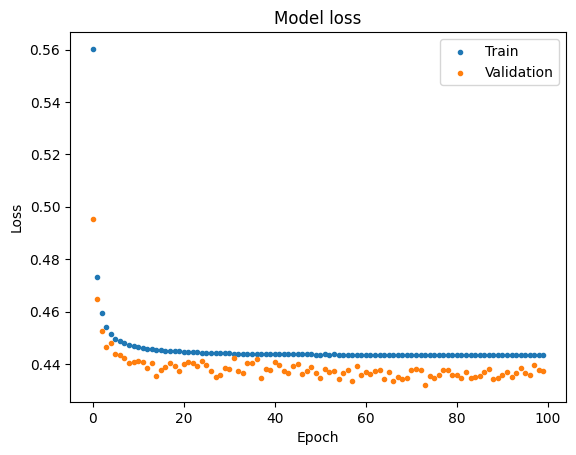

In [88]:
plot_loss(history1)

A graph is plotted to show how the area under curve changes as the number of passes increases

In [89]:
def plot_auc(history):
    '''
    plot the area under curve in the training and validating history of a machine learning model
    
    Argument:
    history: the history returned by model.fit(method), it consist of the training history
    
    Return:
    None
    
    '''
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(history.history['auc'], 'b.', label='Training AUC')
    ax.plot(history.history['val_auc'], 'r.', label='Validation AUC')
    ax.set_xlim([0, len(history.history['auc'])])
    ax.title.set_text('Training and Validation AUC')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('AUC')
    ax.legend()
    ax.grid()
    _ = plt.show()

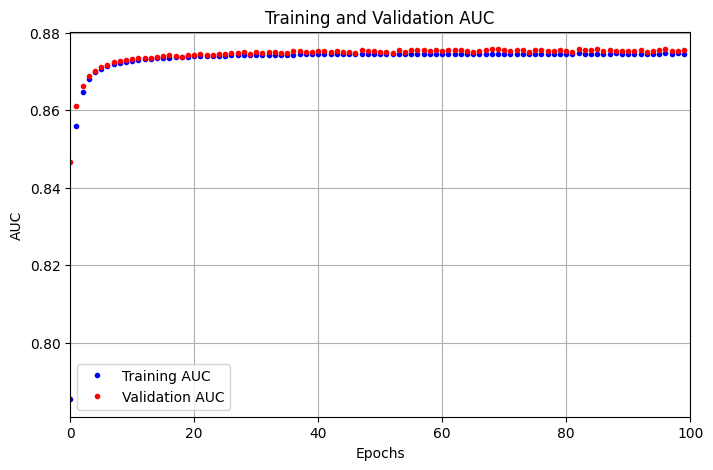

In [90]:
plot_auc(history1)

Based on the accuracy (0.88) on validation and the balanced accuracy score(0.79) on validation, a model that does better than the baseline has been developed as they are doing better than the baseline accuracy(0.78) and baseline balanced accuracy score(0.50)

<h2 id='chpt6'>6. Scaling up: developing a model that overfits</h2>

As mentioned in chapter 4.5.6 of the Deep Learning with Python by Chollet, there are a few ways to scale up and develop an overfit model. Three ways introduced in the book are "1. Add Layers, 2. Make the layer bigger, 3. train for more epochs"(Chollet, 2018). All three ways will be used ro scale up this model. Firstly, a multi-layered learning algorith will be used. Secondly, the size of layer will be increased by increasing the unit from 16 to 32. Thirdly, the epochs will increase from 100 to 200. The rest of the parameters are kept constant.

In [94]:
#set hyperparameters for hidden layers
hidden_layers = 4
units = 32
activation = 'relu'
input_shape = X_train.shape[1]
dropout = 0.2

#set hyperparameters for output layer
output_units = 1
output_activation = 'sigmoid'

#set the compiling parameters
loss_function = 'binary_crossentropy'
metrics = ['accuracy', tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

#set the epochs to be larger than orginal
epochs = 200

unlike the first model, more layers were used as the variable hidden_layer is set to 4 (minium 3 for deep learning)

In [95]:
#create the model
multi_layer_model = Sequential()

#add four hidden layers with dropout
for layer in range(hidden_layers):
    multi_layer_model.add(Dense(units, activation=activation, input_shape=(input_shape,)))
    if dropout > 0.0:
        multi_layer_model.add(Dropout(dropout))

#add output layer
multi_layer_model.add(Dense(output_units, activation=output_activation))

#build the model
multi_layer_model.build((None, input_shape))

#compile the model
multi_layer_model.compile(optimizer='rmsprop', loss=loss_function, metrics=metrics)

In [96]:
multi_layer_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                3840      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 32)               

In [97]:
#train the model on the training data
history2 = multi_layer_model.fit(using_X_train.toarray(), using_y_train.to_numpy(), class_weight=class_weights,
                    batch_size=batch_size, epochs=epochs, 
                    validation_data=(X_vali.toarray(), y_vali.to_numpy()),
                    verbose=0)

In [98]:
# Evaluate the model on the validation data and return the results
vali_score_mul = multi_layer_model.evaluate(X_vali.toarray(), y_vali.to_numpy(), verbose=0)[1:]

In [100]:
model_validation(vali_score_mul,y_vali,baseline_bac,baseline_ac,baseline_pr,baseline_rc,vali_score_mul)

Validation accracy balanced accuracy score: 0.79
baseline balanced accuracy score: 0.50
a better model is developed
--------------------------------------------------
Validation accracy: 0.82
baseline accuracy: 0.78
a better model is developed
--------------------------------------------------
Validation precision: 0.58
baseline precision: 0.78
--------------------------------------------------
Validation recall: 0.77
baseline recall: 1.00
--------------------------------------------------
Validation area under curve(AUC): 0.89
--------------------------------------------------


As compared to the orginal one_layered learing algorithm, the new multi-layed network does better.

In [101]:
model_validation(fst_model,y_vali,baseline_bac,baseline_ac,baseline_pr,baseline_rc,vali_score)

Validation accracy balanced accuracy score: 0.79
baseline balanced accuracy score: 0.50
a better model is developed
--------------------------------------------------
Validation accracy: 0.81
baseline accuracy: 0.78
a better model is developed
--------------------------------------------------
Validation precision: 0.55
baseline precision: 0.78
--------------------------------------------------
Validation recall: 0.81
baseline recall: 1.00
--------------------------------------------------
Validation area under curve(AUC): 0.89
--------------------------------------------------


<p id='hist'>after reviewing the validity score, the model's area under curve and loss function are plotted </p>

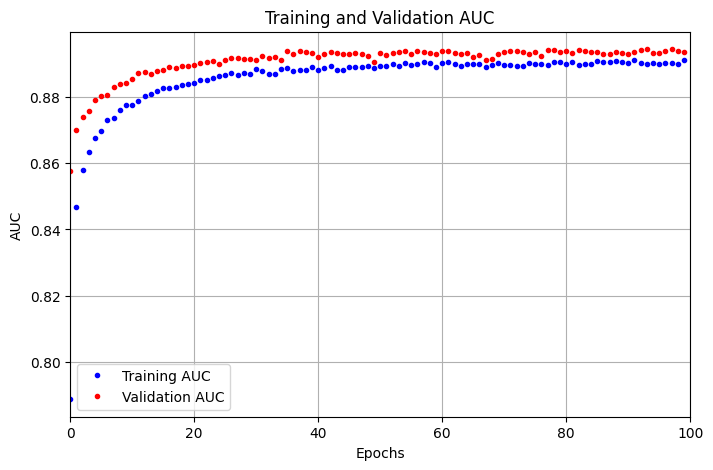

In [92]:
plot_auc(history2)

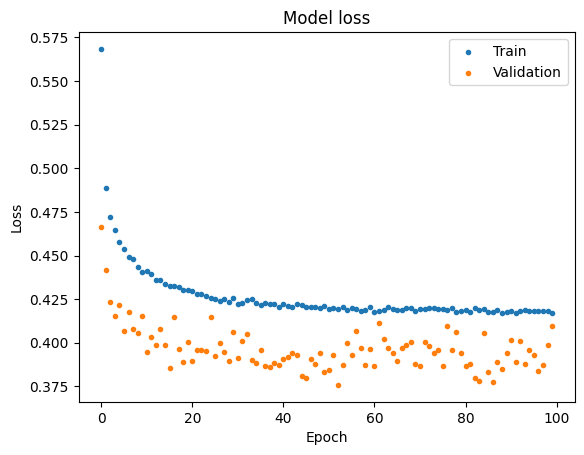

In [93]:
plot_loss(history2)

<h2 id='chpt7'>7. Regularizing the model and tuning hyperparameters</h2>

As recommended by the Deep Learning with Python by Chollet, there are a few things to consider when regularizing the model and tuning the hyperparameters. Some of them includes"Add dropout, Try different architectures, add L1/L2 regularization try different hyperparameters, optionally iterate on feature engineering" (Chollet, 2018). This report will consider them one by one.

<h3>7.1 Add dropout</h3>

As the original network already contains a dropout of 0.2. This will not be used at the moment, unless the model needs to be future trained.

<h3>7.2 Different architectures</h3>

There are two ways to change the architechture, adding or removing layers. As the multi-layered network seems to be performing better as compared to the one-layered network, this section will attempt to create a network that contains more layers. This could be helpful in impoving the performance of the model. Two simple function for building and training model were defined to simplify the workflow.

In [103]:
#set hyperparameters that is different
hidden_layers = 6

In [107]:
def build_model(model):
    # Add four hidden layers with dropout
    for layer in range(hidden_layers):
        model.add(Dense(units, activation=activation, input_shape=(input_shape,)))
        if dropout > 0.0:
            model.add(Dropout(dropout))

    # Add output layer
    model.add(Dense(output_units, activation=output_activation))

    # Build the model
    model.build((None, input_shape))

    # Compile the model
    model.compile(optimizer='rmsprop', loss=loss_function, metrics=metrics)
    
    return model

In [111]:
#create the model
six_layer_model = Sequential()
six_layer_model = build_model(six_layer_model)

In [112]:
six_layer_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 32)                3840      
                                                                 
 dropout_20 (Dropout)        (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 32)                1056      
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_27 (Dense)            (None, 32)                1056      
                                                                 
 dropout_22 (Dropout)        (None, 32)                0         
                                                                 
 dense_28 (Dense)            (None, 32)               

In [120]:
def training(model):
    #train the model on the training data
    _history = model.fit(using_X_train.toarray(), using_y_train.to_numpy(), class_weight=class_weights,
                        batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_vali.toarray(), y_vali.to_numpy()),
                        verbose=0)
    return model

In [122]:
#evaluate the model on the validation data and return the results
vali_score_six = training(six_layer_model).evaluate(X_vali.toarray(), y_vali.to_numpy(), verbose=0)[1:]

In [123]:
model_validation(vali_score_six,y_vali,baseline_bac,baseline_ac,baseline_pr,baseline_rc,vali_score_mul)

Validation accracy balanced accuracy score: 0.79
baseline balanced accuracy score: 0.50
a better model is developed
--------------------------------------------------
Validation accracy: 0.82
baseline accuracy: 0.78
a better model is developed
--------------------------------------------------
Validation precision: 0.58
baseline precision: 0.78
--------------------------------------------------
Validation recall: 0.77
baseline recall: 1.00
--------------------------------------------------
Validation area under curve(AUC): 0.89
--------------------------------------------------


based on the validation score, there is no significant difference between this model and the one with 4 layers. Moreover, as mentioned ealier in [section 2](#chpt2), this model should focus on imporving recall. However, the value of recall decreased for this six layered model.

As it is recommended to stay with model with lesser layer when the final output does not differ by much, this report will stick with the previouse model.

Moreover, the model with lesser layer will also be checked.

In [126]:
#set hyperparameters that is different
hidden_layers = 3

#create the model
three_layer_model = Sequential()
three_layer_model = build_model(three_layer_model)

#train and evaluate the model on the validation data and return the results
vali_score_three = training(three_layer_model).evaluate(X_vali.toarray(), y_vali.to_numpy(), verbose=0)[1:]

#validation
model_validation(vali_score_three,y_vali,baseline_bac,baseline_ac,baseline_pr,baseline_rc,vali_score_mul)

Validation accracy balanced accuracy score: 0.79
baseline balanced accuracy score: 0.50
a better model is developed
--------------------------------------------------
Validation accracy: 0.82
baseline accuracy: 0.78
a better model is developed
--------------------------------------------------
Validation precision: 0.58
baseline precision: 0.78
--------------------------------------------------
Validation recall: 0.77
baseline recall: 1.00
--------------------------------------------------
Validation area under curve(AUC): 0.89
--------------------------------------------------


This model performs similar to the 4 layer model. To simplify the model, this 3 layer model will be used. 

Trying model with lesser layer:

In [133]:
#set hyperparameters that is different
hidden_layers = 2

#create the model
two_layer_model = Sequential()
two_layer_model = build_model(two_layer_model)

#train and evaluate the model on the validation data and return the results
vali_score_two = training(two_layer_model).evaluate(X_vali.toarray(), y_vali.to_numpy(), verbose=0)[1:]

#validation
model_validation(vali_score_two,y_vali,baseline_bac,baseline_ac,baseline_pr,baseline_rc,vali_score_mul)

Validation accracy balanced accuracy score: 0.79
baseline balanced accuracy score: 0.50
a better model is developed
--------------------------------------------------
Validation accracy: 0.82
baseline accuracy: 0.78
a better model is developed
--------------------------------------------------
Validation precision: 0.58
baseline precision: 0.78
--------------------------------------------------
Validation recall: 0.77
baseline recall: 1.00
--------------------------------------------------
Validation area under curve(AUC): 0.89
--------------------------------------------------


In [140]:
#set hyperparameters that is different
hidden_layers = 1

#create the model
s_layer_model = Sequential()
s_layer_model = build_model(s_layer_model)

#train and evaluate the model on the validation data and return the results
vali_score_s = training(s_layer_model).evaluate(X_vali.toarray(), y_vali.to_numpy(), verbose=0)[1:]

#validation
model_validation(vali_score_s,y_vali,baseline_bac,baseline_ac,baseline_pr,baseline_rc,vali_score_mul)

Validation accracy balanced accuracy score: 0.79
baseline balanced accuracy score: 0.50
a better model is developed
--------------------------------------------------
Validation accracy: 0.82
baseline accuracy: 0.78
a better model is developed
--------------------------------------------------
Validation precision: 0.58
baseline precision: 0.78
--------------------------------------------------
Validation recall: 0.77
baseline recall: 1.00
--------------------------------------------------
Validation area under curve(AUC): 0.89
--------------------------------------------------


All models perform similar to the 4 layer model. To simplify the model, the last model with 1 hidden layer will be used.

<h3>7.3 Adding regularization</h3>

Regularization is added using kernel_regularizer

In [135]:
from tensorflow.keras.regularizers import L1

In [136]:
# Create the model
reg_model = Sequential()

# Add four hidden layers with dropout and L1 regularization
for layer in range(hidden_layers):
    reg_model.add(Dense(units, activation=activation, input_shape=(input_shape,), kernel_regularizer=L1(l=0.01)))
    if dropout > 0.0:
        reg_model.add(Dropout(dropout))

# Add output layer
reg_model.add(Dense(output_units, activation=output_activation))

# Build the model
reg_model.build((None, input_shape))

# Compile the model
reg_model.compile(optimizer='rmsprop', loss=loss_function, metrics=metrics)

In [137]:
reg_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 32)                3840      
                                                                 
 dropout_40 (Dropout)        (None, 32)                0         
                                                                 
 dense_53 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,873
Trainable params: 3,873
Non-trainable params: 0
_________________________________________________________________


In [138]:
#train and evaluate the model on the validation data and return the results
vali_score_reg = training(reg_model).evaluate(X_vali.toarray(), y_vali.to_numpy(), verbose=0)[1:]

#validation
model_validation(vali_score_reg,y_vali,baseline_bac,baseline_ac,baseline_pr,baseline_rc,vali_score_mul)

Validation accracy balanced accuracy score: 0.79
baseline balanced accuracy score: 0.50
a better model is developed
--------------------------------------------------
Validation accracy: 0.82
baseline accuracy: 0.78
a better model is developed
--------------------------------------------------
Validation precision: 0.58
baseline precision: 0.78
--------------------------------------------------
Validation recall: 0.77
baseline recall: 1.00
--------------------------------------------------
Validation area under curve(AUC): 0.89
--------------------------------------------------


This set of reading is also very similar to that of 1-hidden layer network

<h3>7.4 Trying different hyperparameters</h3>

As the model has tried to over fit the data by increasing the echos and number of unit. Here the model will be tested on trying a smaller set of hyperparameters

With reference to the plot of [history2](#hist), the model stablise after around 40 epochs

In [139]:
#set different hyperparameters for hidden layers
hidden_layers = 1
units = 8

#set the epochs to be smaller than orginal
epochs = 40

In [141]:
#create the model sh stands for smaller hyperparameter
sh_layer_model = Sequential()
sh_layer_model = build_model(sh_layer_model)

#train and evaluate the model on the validation data and return the results
vali_score_sh = training(sh_layer_model).evaluate(X_vali.toarray(), y_vali.to_numpy(), verbose=0)[1:]

#validation
model_validation(vali_score_sh,y_vali,baseline_bac,baseline_ac,baseline_pr,baseline_rc,vali_score_mul)

Validation accracy balanced accuracy score: 0.79
baseline balanced accuracy score: 0.50
a better model is developed
--------------------------------------------------
Validation accracy: 0.82
baseline accuracy: 0.78
a better model is developed
--------------------------------------------------
Validation precision: 0.58
baseline precision: 0.78
--------------------------------------------------
Validation recall: 0.77
baseline recall: 1.00
--------------------------------------------------
Validation area under curve(AUC): 0.89
--------------------------------------------------


trying even smaller hyperparameters:

In [146]:
#set different hyperparameters for hidden layers
hidden_layers = 1
units = 8

#set the epochs to be smaller than orginal
epochs = 35
#create the model sh stands for smaller hyperparameter
sh_layer_model = Sequential()
sh_layer_model = build_model(sh_layer_model)

#train and evaluate the model on the validation data and return the results
vali_score_sh = training(sh_layer_model).evaluate(X_vali.toarray(), y_vali.to_numpy(), verbose=0)[1:]

#validation
model_validation(vali_score_sh,y_vali,baseline_bac,baseline_ac,baseline_pr,baseline_rc,vali_score_mul)

Validation accracy balanced accuracy score: 0.79
baseline balanced accuracy score: 0.50
a better model is developed
--------------------------------------------------
Validation accracy: 0.82
baseline accuracy: 0.78
a better model is developed
--------------------------------------------------
Validation precision: 0.58
baseline precision: 0.78
--------------------------------------------------
Validation recall: 0.77
baseline recall: 1.00
--------------------------------------------------
Validation area under curve(AUC): 0.89
--------------------------------------------------


As shown in the lost graph of [history2](#hist), the loss could become larger when epochs are set below 35. Thus, the final model for the data would be <b>using 8 unit for hidden neurons, 1 hidden-layer, epochs of 35</b> with all other hyperparameters set to be the same as the original model.

<h4>Problem with the final model and future improvement</h4>

There is no significant improvement from the original simple model that does better than the baseline. Moreover, all the plots in the report show the vertical axis has a very small range, indicating that the model did not improve the prediction significantly as the epochs increases. 

As this report aims to predict the weather in terms of whether or not it will be raining, the factors affecting rain could be beyond the scope of the data collected. Thus, other information could be required to study this topic.

Moreover, the baseline of this model is a very simple prediction as the data is very imbalanced. In the future, this can be improved by seeking advice from experts in the meteorological section to improve the baseline so that there will be a better gauge of how good or bad the model performs.